<a href="https://colab.research.google.com/github/BuczynskiRafal/pipe_calculations/blob/main/Catchments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install extensions

In [1]:
!pip install pyswmm
!pip install swmmio

# Import

In [13]:
import os
import swmmio
import tempfile
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from swmmio.utils.dataframes import dataframe_from_inp
from swmmio.utils.text import get_inp_sections_details
from swmmio.utils.modify_model import replace_inp_section
from swmmio.version_control.utils import write_inp_section
from pyswmm import Simulation, Nodes, Links, Subcatchments, Output

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE, weight='normal')          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Prepare model for managing

In [3]:
#initialize a baseline model object
baseline = swmmio.Model('example.inp')
#create copy the base model
newfilepath = os.path.join(baseline.inp.name + "_" + 'copy' + '.inp')
# save new file
baseline.inp.save(newfilepath)

# Explore model data

In [4]:
model = swmmio.Model('example_copy.inp')
# df_subcatchments = dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')
df_subcatchments = model.subcatchments.dataframe
df_subcatchments

,Raingage,Outlet,...,RouteTo,coords
Name,,,,,
S1,Raingage2,J1,...,OUTLET,"[(777180.0, 592590.0), (777180.0, 592585.0), (777175.0, 592585.0), (777175.0, 592590.0), (777180.0, 592590.0)]"
S2,Raingage2,J1,...,OUTLET,"[(777174.995, 592577.561), (777179.978, 592577.122), (777180.027, 592582.593), (777174.995, 592582.593), (777174.995, 592577.561)]"
S3,Raingage2,J1,...,OUTLET,"[(777176.607, 592571.748), (777180.32, 592572.139), (777182.274, 592575.168), (777174.849, 592575.265), (777176.607, 592571.748)]"
S4,Raingage2,J1,...,OUTLET,"[(777188.381, 592573.214), (777187.941, 592574.972), (777183.496, 592574.972), (777183.496, 592571.455), (777188.381, 592573.214)]"
S5,Raingage2,J1,...,OUTLET,"[(777183.74, 592569.94), (777177.731, 592569.647), (777178.171, 592567.302), (777183.74, 592569.94)]"
S6,Raingage2,J1,...,OUTLET,"[(777187.355, 592563.052), (777191.214, 592563.345), (777190.042, 592567.644), (777183.984, 592566.423), (777183.935, 592562.368), (777187.355, 592563.052)]"


In [5]:
''' PySWMM doesn't allow to set percent imprevious parameter.
It's important to check impact this feature on runoff.
This is the reason to overide imprevious value in dataftame
and overwrite model with new data.
'''
def overwrite_percent_imprevious(value: float, subcatchment_id: str, file_path: str = 'example_copy.inp') -> None:
    model = swmmio.Model(file_path)

    #create a dataframe of the model's subcatchments
    subcatchments = swmmio.utils.dataframes.dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')

    # subcatchments = model.subcatchments.dataframe
    subcatchments.loc[subcatchment_id, "PercImperv"] = value

    #overwrite file with new data
    swmmio.utils.modify_model.replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)

# overwrite_percent_imprevious(value=50, subcatchment_id='S1', file_path='example_copy.inp')


In [9]:
def calculate(subcatchment_id=None, conduit_id=None, file_path='example_copy.inp'):
    with Simulation(file_path) as sim:
        catchment = Subcatchments(sim)[subcatchment_id]
        conduit = Links(sim)[conduit_id]
        for _ in sim: pass
        return catchment.statistics, conduit.conduit_statistics


def simulate_catchment_features(subcatchment_id=None, conduit_id=None, min=1, max=100, step=10, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    conduit_data = {'flow_turn_sign': [], 'flow_turns': [], 'peak_depth': [], 'peak_flow': [], 'peak_flow_date': [], 'peak_velocity': [], 'time_capacity_limited': [], 'time_courant_crit': [], 'time_full_downstream': [], 'time_full_flow': [], 'time_full_upstream': [], 'time_normal_flow': []}
    iterator = [min]
    counter = min
    while counter < max:
        counter += step
        iterator.append(counter)
    slope, percent_impervious, area = [], [], []
    for a in range(1, 16, 1):
        for s in iterator:
            for i in iterator:
                slope.append(s)
                percent_impervious.append(i)
                area.append(a)
                model = swmmio.Model(file_path)
                subcatchments = swmmio.utils.dataframes.dataframe_from_inp(file_path, '[SUBCATCHMENTS]')
                subcatchments.loc[subcatchment_id, "PercSlope"] = s/100
                subcatchments.loc[subcatchment_id, "PercImperv"] = i
                subcatchments.loc[subcatchment_id, "Area"] = a
                replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)
                catchment_stats = calculate(subcatchment_id=subcatchment_id,  conduit_id=conduit_id, file_path=model.inp.path)
                conduit_stats = conduit
                for key in catchment_data:
                    catchment_data[key].append(catchment_stats[key])
                counter += step
    catchment_data["slope"] = slope
    catchment_data["percent_impervious"] = percent_impervious
    catchment_data["area"] = area
    return pd.DataFrame(data=catchment_data)


In [ ]:
analyse = simulate_catchment_features(subcatchment_id='S1', min=1, max=100, step=10, file_path='example_copy.inp')

In [ ]:
analyse.head()

# Simulate percent imprevious feature

## Prepare method for simulation

In [6]:
def simulate_percent_imprevious(subcatchment_id=None, min=0.1, max=100, step=10, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    model = swmmio.Model(file_path)
    percent_impervious = []
    counter = min
    while counter < max:
        subcatchments = swmmio.utils.dataframes.dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')
        subcatchments.loc[subcatchment_id, "PercImperv"] = counter
        percent_impervious.append(counter)
        replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)

        with Simulation(model.inp.path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            for _ in sim: pass
            catchment_stats = catchment.statistics
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
        counter += step
    catchment_data["percent_impervious"] = percent_impervious
    return pd.DataFrame(data=catchment_data)

## Get imprevious data

In [7]:
df_percent_imprevious =  simulate_percent_imprevious(subcatchment_id='S1', min=1, max=100, step=1, file_path='example_copy.inp')

In [9]:
df_percent_imprevious.shape

(99, 5)

## Subcatchments data output


In [16]:
# Correlation runoff vs. percent_impervious
df_cor = pd.DataFrame()
df_cor = df_cor.assign(runoff=df_percent_imprevious['runoff'])
df_cor = df_cor.assign(percent_impervious=df_percent_imprevious['percent_impervious'])
correlation, p_value = spearmanr(df_cor['runoff'], df_cor['percent_impervious'])
print(f"Spearman Correlation: {correlation}, P-value: {p_value}")

Spearman Correlation: 0.9999999999999999, P-value: 0.0


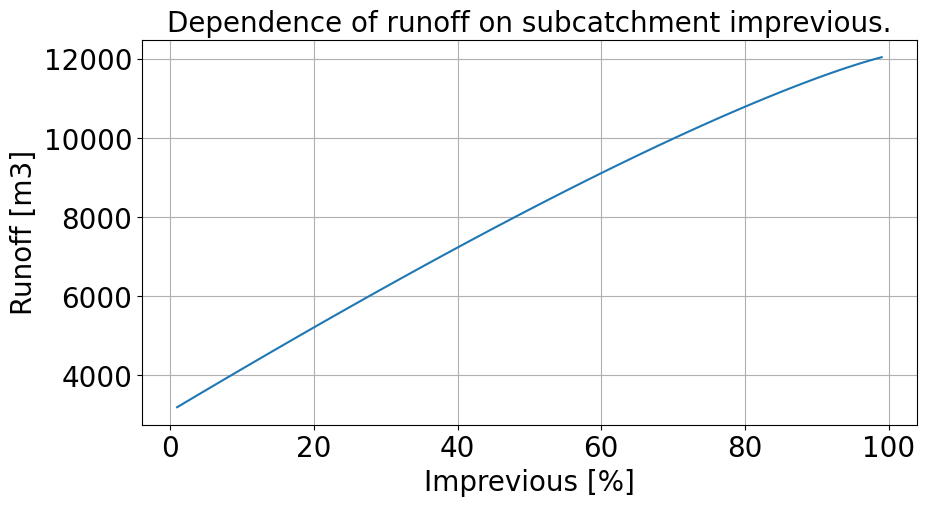

In [10]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_percent_imprevious['percent_impervious'], df_percent_imprevious['runoff'])
plt.title('Dependence of runoff on subcatchment imprevious.')
plt.xlabel('Imprevious [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment imprevious.


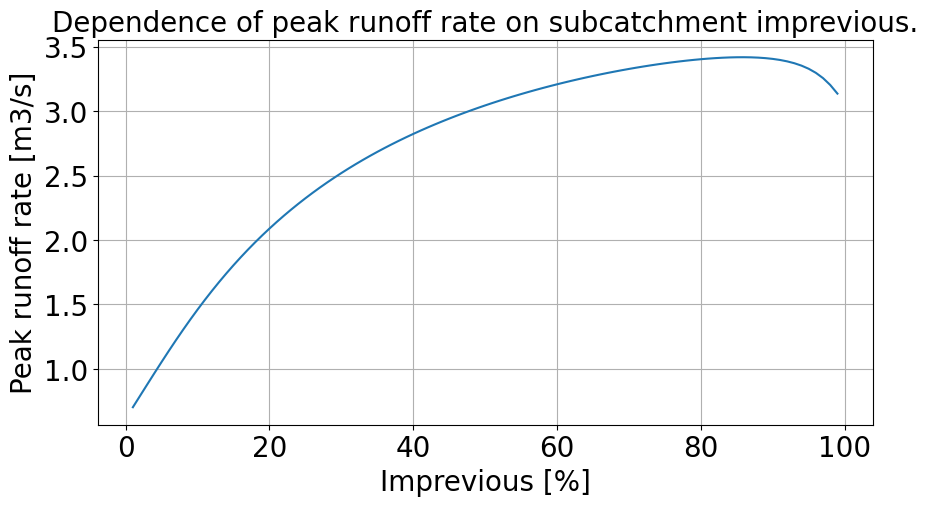

In [11]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_percent_imprevious['percent_impervious'], df_percent_imprevious['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment imprevious.')
plt.xlabel('Imprevious [%]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment imprevious


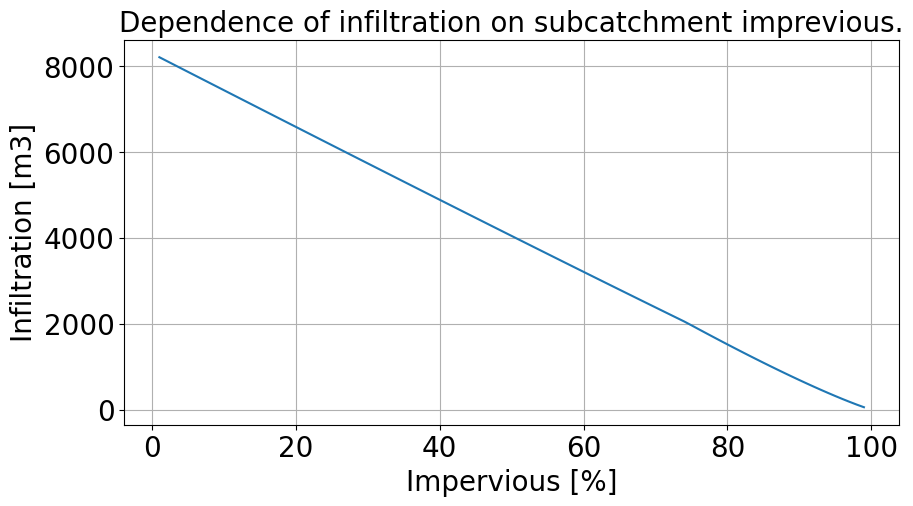

In [12]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_percent_imprevious['percent_impervious'], df_percent_imprevious['infiltration'])
plt.title('Dependence of infiltration on subcatchment imprevious.')
plt.xlabel('Impervious [%]')
plt.ylabel('Infiltration [m3]')
plt.grid(True)
plt.show()

# Simulate percent slope feature

## Prepare methoed for analyse slope

In [17]:
def simulate_catchments_slope(subcatchment_id=None, conduit_id=None, min=1, max=100, step=1, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    conduit_data = {'flow_turn_sign': [], 'flow_turns': [], 'peak_depth': [], 'peak_flow': [], 'peak_flow_date': [], 'peak_velocity': [], 'time_capacity_limited': [], 'time_courant_crit': [], 'time_full_downstream': [], 'time_full_flow': [], 'time_full_upstream': [], 'time_normal_flow': []}
    slope = []
    counter = min
    while counter < max:
        with Simulation(file_path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            conduit = Links(sim)[conduit_id]
            catchment.slope = counter/100
            for _ in sim:
                pass
            catchment_stats = catchment.statistics
            conduit_stats = conduit.conduit_statistics
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
            for key in conduit_data:
                conduit_data[key].append(conduit_stats[key])
            slope.append(counter)
        counter += step
    catchment_data["slope"] = slope
    return pd.DataFrame(data={**catchment_data, **conduit_data})

## Get slope data

In [18]:
df_slope = simulate_catchments_slope("S1", "C3")

In [22]:
df_slope.columns

Index(['runoff', 'peak_runoff_rate', 'infiltration', 'evaporation', 'slope',
       'flow_turn_sign', 'flow_turns', 'peak_depth', 'peak_flow',
       'peak_flow_date', 'peak_velocity', 'time_capacity_limited',
       'time_courant_crit', 'time_full_downstream', 'time_full_flow',
       'time_full_upstream', 'time_normal_flow'],
      dtype='object')

## Subcatchment data output

In [25]:
# Correlation runoff vs. percent_impervious
df_cor = pd.DataFrame()
df_cor = df_cor.assign(runoff=df_slope['runoff'])
df_cor = df_cor.assign(slope=df_slope['slope'])
correlation, p_value = spearmanr(df_cor['runoff'], df_cor['slope'])
print(f"Spearman Correlation: {correlation}, P-value: {p_value}")

Spearman Correlation: 0.9999999999999999, P-value: 0.0


### Dependence of runoff on subcatchment slope.

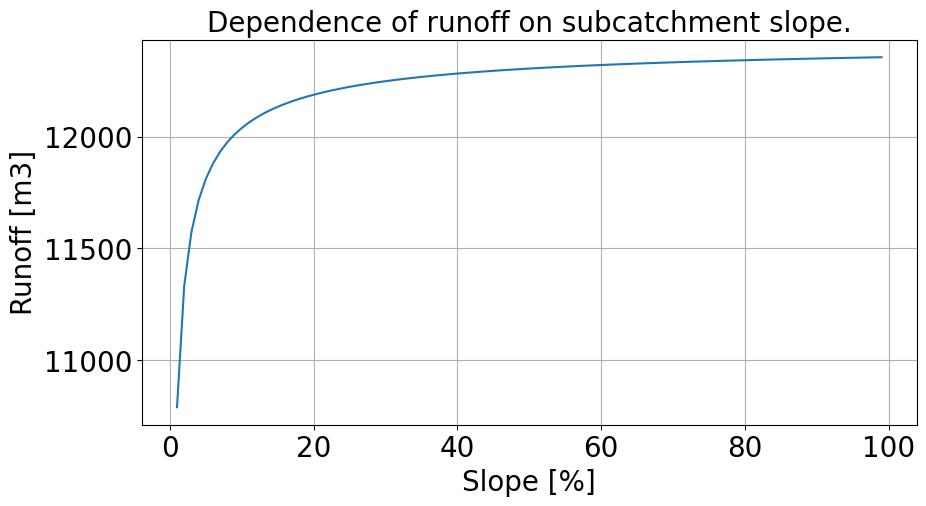

In [26]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['runoff'])
plt.title('Dependence of runoff on subcatchment slope.')
plt.xlabel('Slope [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment slope

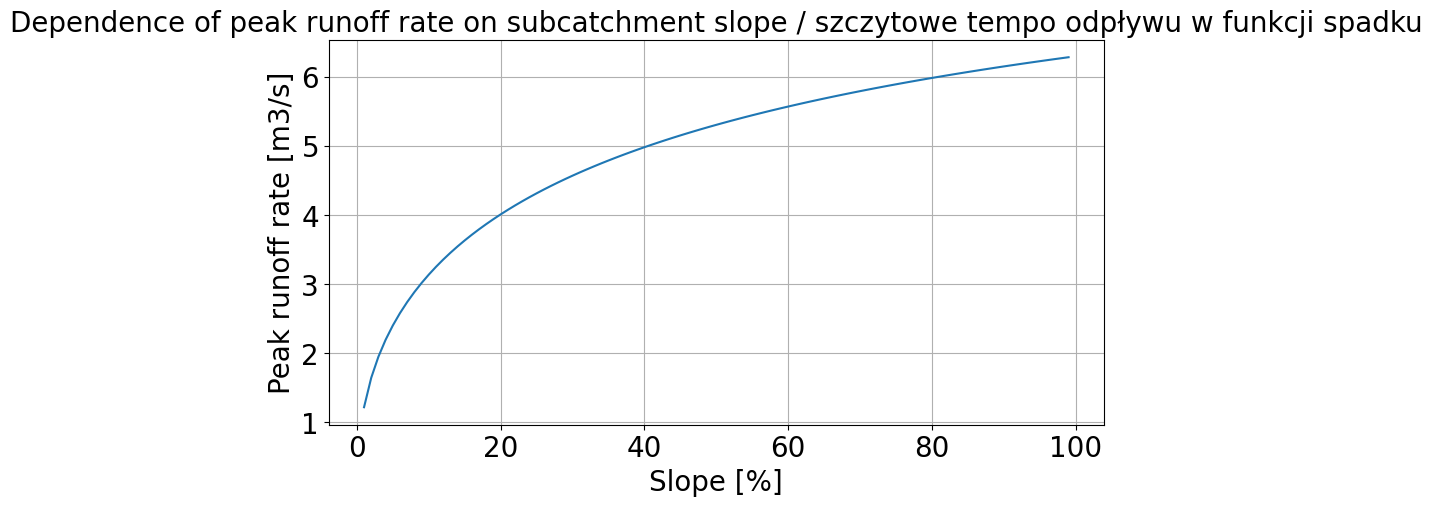

In [27]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment slope / szczytowe tempo odpływu w funkcji spadku')
plt.xlabel('Slope [%]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment slope

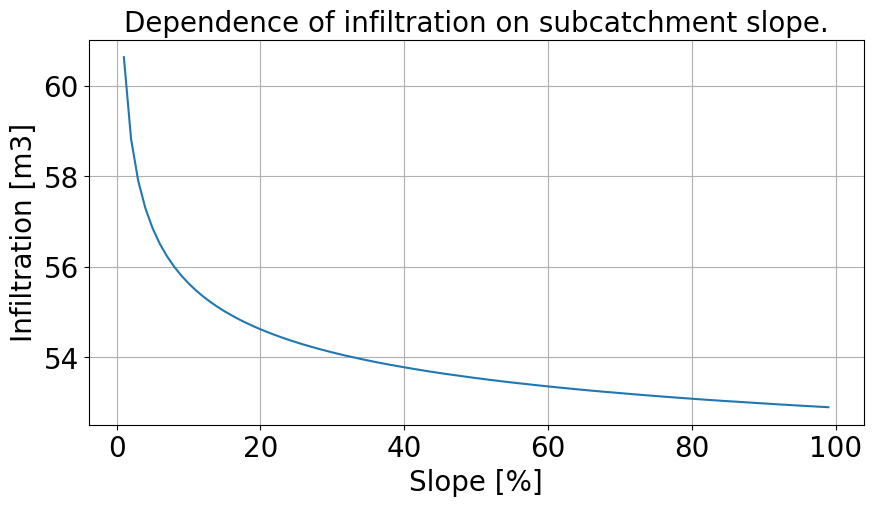

In [28]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['infiltration'])
plt.title('Dependence of infiltration on subcatchment slope.')
plt.xlabel('Slope [%]')
plt.ylabel('Infiltration [m3]')
plt.grid(True)
plt.show()

### Dependence of maximal flow on subcatchment slope.

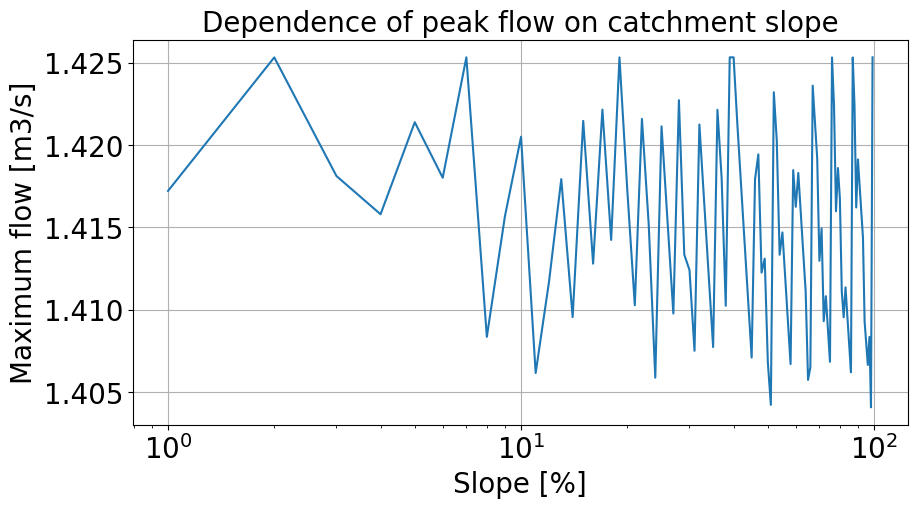

In [29]:
# maksymaly przepływ [m3/s] w funkcji spadku terenu zlewni.
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['peak_flow'])
plt.title('Dependence of peak flow on catchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximum flow [m3/s]')
plt.grid(True)
plt.show()

### Dependence of maximal velocity on subcatchment slope


In [ ]:
# peak_velocity - maksymalna prędkość przepływu [m/s]
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['peak_velocity'])
plt.title('Dependence of peak velocity on catchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximum velocity [m/s]')
plt.grid(True)
plt.show()

### Dependence of maximal pipe filling on subcatchment slope.

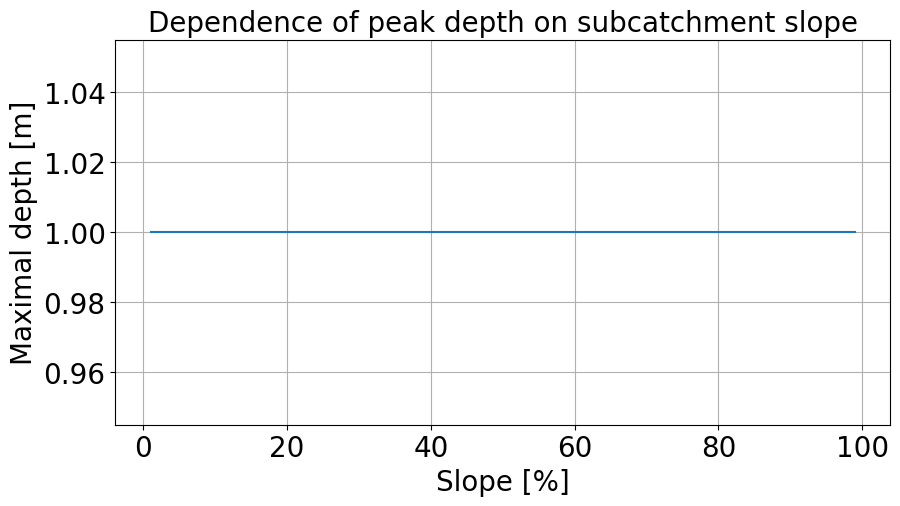

In [30]:
# maksymalna wysokość napełnienia kanału  w sunkcji spadku terenu zlewni [m]
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['peak_depth'])
plt.title('Dependence of peak depth on subcatchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximal depth [m]')
plt.grid(True)
plt.show()

# Simulate N-Imperv (Mannings N for imprevious area)

### Description for N-Imperv value
Source: McCuen, R. et al. (1996), Hydrology, FHWA-SA-96-067, Federal Highway Administration, Washington, DC.


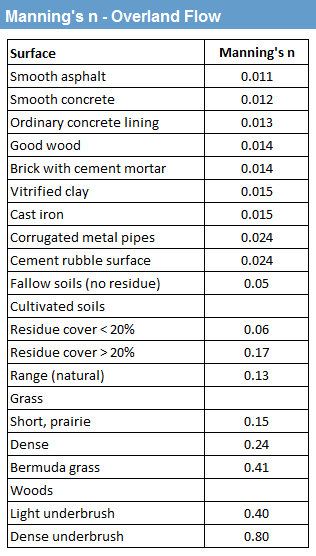


## Prepare method for simulation

In [31]:
def simulate_n_imprev(subcatchment_id=None, file_path='example_copy.inp'):
    minings_n = np.sort([0.011, 0.012, 0.013, 0.014, 0.015, 0.024, 0.05, 0.06, 0.17, 0.13, 0.15, 0.24, 0.41, 0.4, 0.8])
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    percent_impervious = []
    model = swmmio.Model(file_path)
    for n in minings_n:
        subareas = model.inp.subareas
        subareas.loc["S1", "N-Imperv"] = n
        model.inp.subareas = subareas
        replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)

        with Simulation(model.inp.path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            for _ in sim: pass
            catchment_stats = catchment.statistics
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
    df = pd.DataFrame(data=catchment_data)
    df["N-Imperv"] = minings_n
    return df

## Get N-Impervious data

In [32]:
df_n_impervious = simulate_n_imprev("S1")

In [34]:
df_n_impervious.columns

Index(['runoff', 'peak_runoff_rate', 'infiltration', 'evaporation',
       'N-Imperv'],
      dtype='object')

## Subcatchment data output

In [40]:
# Correlation runoff vs. percent_impervious
df_cor = pd.DataFrame()
df_cor = df_cor.assign(runoff=df_n_impervious['runoff'])
df_cor = df_cor.assign(N_Imperv=df_n_impervious['N-Imperv'])
# df_cor.head()
correlation, p_value = spearmanr(df_cor['runoff'], df_cor['N_Imperv'])
print(f"Spearman Correlation: {correlation}, P-value: {p_value}")

Spearman Correlation: -1.0, P-value: 0.0


### Dependence of runoff on subcatchment imprevious.

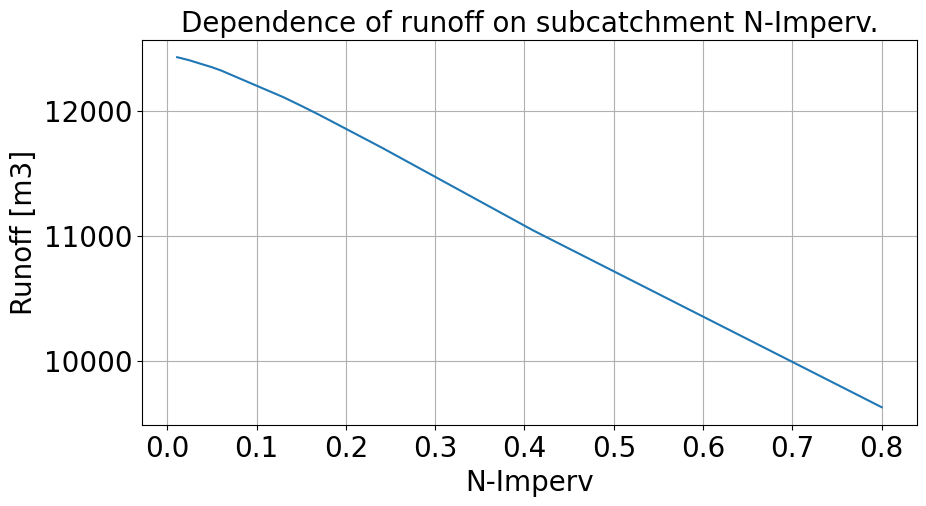

In [41]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_impervious['N-Imperv'], df_n_impervious['runoff'])
plt.title('Dependence of runoff on subcatchment N-Imperv.')
plt.xlabel('N-Imperv')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment imprevious.

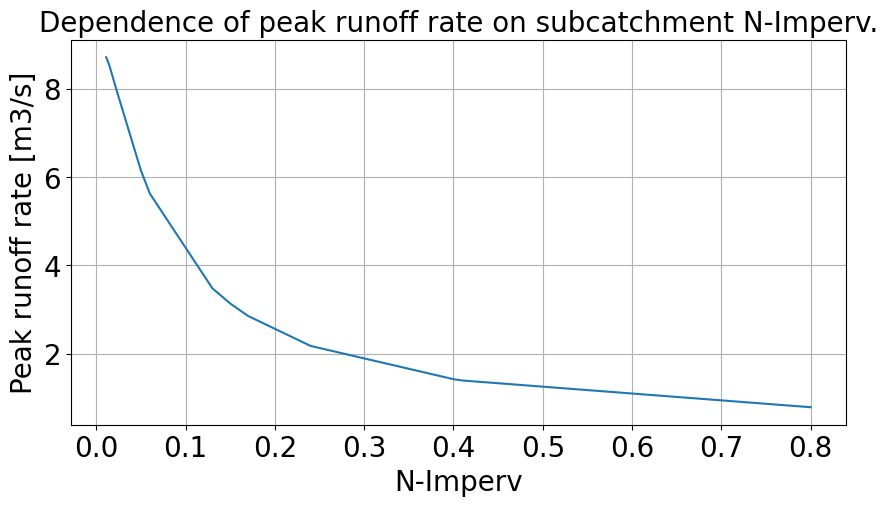

In [42]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_impervious['N-Imperv'], df_n_impervious['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment N-Imperv.')
plt.xlabel('N-Imperv')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment imprevious

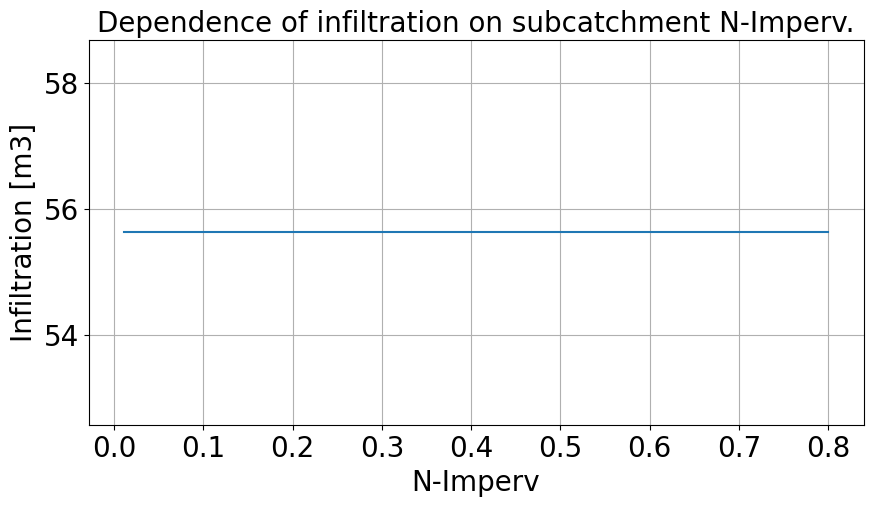

In [43]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_impervious['N-Imperv'], df_n_impervious['infiltration'])
plt.title('Dependence of infiltration on subcatchment N-Imperv.')
plt.xlabel('N-Imperv')
plt.ylabel('Infiltration [m3]')
plt.grid(True)
plt.show()

# Simulate N-Perv (Mannings N for revious area)

## Description
Source: McCuen, R. et al. (1996), Hydrology, FHWA-SA-96-067, Federal Highway Administration, Washington, DC.



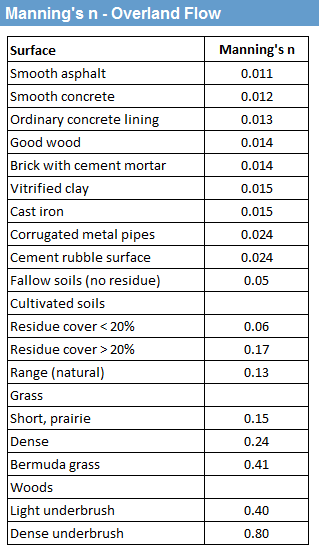

## Prepare method for simulation

In [44]:
def simulate_n_prev(subcatchment_id=None, file_path='example_copy.inp'):
    minings_n = np.sort([0.011, 0.012, 0.013, 0.014, 0.015, 0.024, 0.05, 0.06, 0.17, 0.13, 0.15, 0.24, 0.41, 0.4, 0.8])
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    percent_impervious = []
    model = swmmio.Model(file_path)
    for n in minings_n:
        subareas = model.inp.subareas
        subareas.loc["S1", "N-Perv"] = n
        model.inp.subareas = subareas
        replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)

        with Simulation(model.inp.path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            for _ in sim: pass
            catchment_stats = catchment.statistics
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
    df = pd.DataFrame(data=catchment_data)
    df["N-Perv"] = minings_n
    return df

## Get N-Previous data

In [45]:
df_n_perv = simulate_n_prev("S1")

In [46]:
df_n_perv.shape
df_n_perv.head()

,runoff,peak_runoff_rate,infiltration,evaporation,N-Perv
0,9634.121729,0.789103,50.642127,0.0,0.011
1,9634.043494,0.789122,50.656970,0.0,0.012
2,9633.962718,0.789129,50.692745,0.0,0.013
3,9633.884113,0.789131,50.728054,0.0,0.014
4,9633.810593,0.789131,50.763149,0.0,0.015


## Subcatchments data output

In [47]:
# Correlation runoff vs. percent_impervious
df_cor = pd.DataFrame()
df_cor = df_cor.assign(runoff=df_n_perv['runoff'])
df_cor = df_cor.assign(N_Perv=df_n_perv['N-Perv'])
# df_cor.head()
correlation, p_value = spearmanr(df_cor['runoff'], df_cor['N_Perv'])
print(f"Spearman Correlation: {correlation}, P-value: {p_value}")

Spearman Correlation: -1.0, P-value: 0.0


### Dependence of runoff on subcatchment N-Perv.


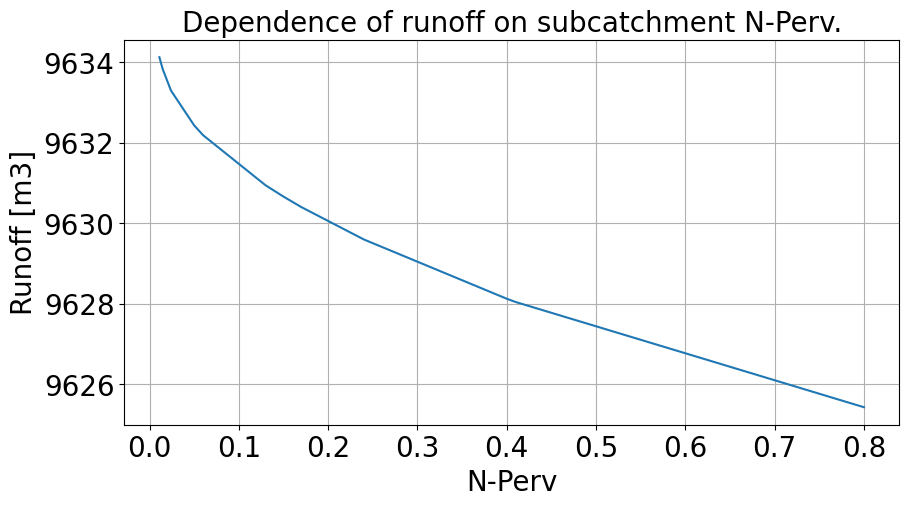

In [48]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_perv['N-Perv'], df_n_perv['runoff'])
plt.title('Dependence of runoff on subcatchment N-Perv.')
plt.xlabel('N-Perv')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment N-Perv.

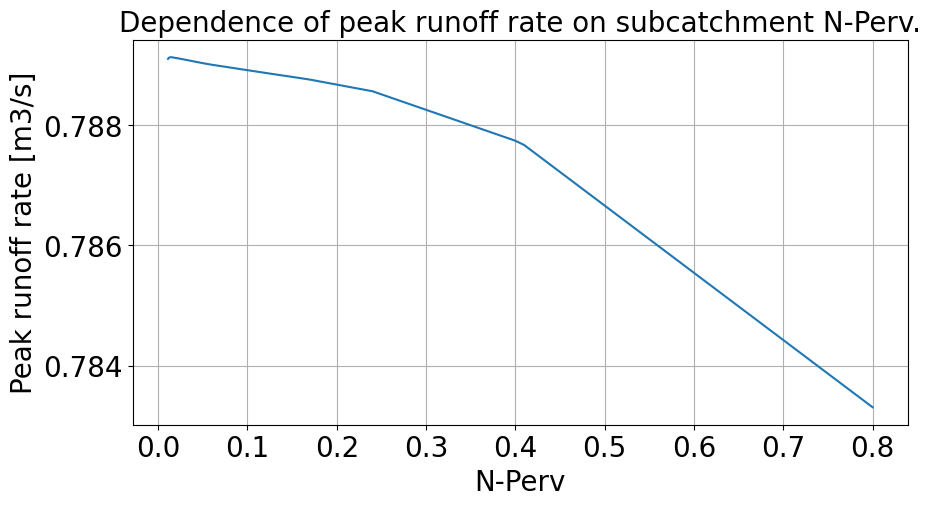

In [49]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_perv['N-Perv'], df_n_perv['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment N-Perv.')
plt.xlabel('N-Perv')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment imprevious

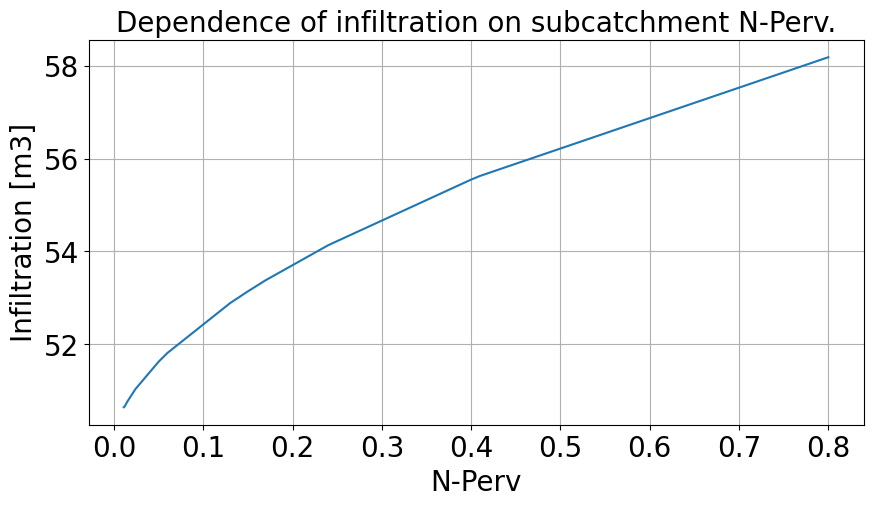

In [50]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_perv['N-Perv'], df_n_perv['infiltration'])
plt.title('Dependence of infiltration on subcatchment N-Perv.')
plt.xlabel('N-Perv')
plt.ylabel('Infiltration [m3]')
plt.grid(True)
plt.show()

# Simulate Destore-Imperv (Depth of depression storage on imprevious area [mm])

## Description
Source: ASCE,(1992), Design & Construction of Urban Stormwater Management Systems, New York, NY.

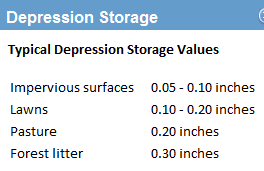



## Prepare method for simulation

In [51]:
def simulate_s_imprev(subcatchment_id=None, file_path='example_copy.inp'):
    typical_values = np.sort([0.05, 0.1, 0.2, 0.3])
    typical_values = [val * 25.4 for val in typical_values]
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    model = swmmio.Model(file_path)
    for n in typical_values:
        subareas = model.inp.subareas
        subareas.loc["S1", "S-Imperv"] = n
        model.inp.subareas = subareas
        replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)

        with Simulation(model.inp.path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            for _ in sim: pass
            catchment_stats = catchment.statistics
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
    df = pd.DataFrame(data=catchment_data)
    df["Destore-Imperv"] = typical_values
    return df

## Get Destore-Imperv data

In [52]:
df_s_imperv = simulate_s_imprev("S1")

In [53]:
df_s_imperv.shape
df_s_imperv.head()

,runoff,peak_runoff_rate,infiltration,evaporation,Destore-Imperv
0,9625.429604,0.783310,58.184783,0.0,1.27
1,9344.491317,0.756910,58.184783,0.0,2.54
2,8792.496889,0.708235,58.184783,0.0,5.08
3,8258.625190,0.665897,58.184783,0.0,7.62


## Subcatchments data output

In [54]:
# Correlation runoff vs. percent_impervious
df_cor = pd.DataFrame()
df_cor = df_cor.assign(runoff=df_s_imperv['runoff'])
df_cor = df_cor.assign(Destore_Imperv=df_s_imperv['Destore-Imperv'])
# df_cor.head()
correlation, p_value = spearmanr(df_cor['runoff'], df_cor['Destore_Imperv'])
print(f"Spearman Correlation: {correlation}, P-value: {p_value}")

Spearman Correlation: -1.0, P-value: 0.0


### Dependence of runoff on subcatchment Destore-Imperv.


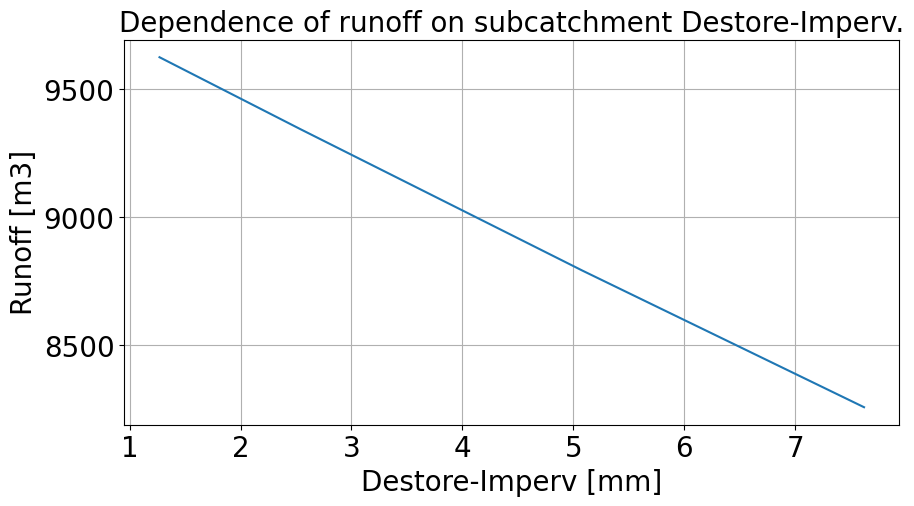

In [55]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_s_imperv['Destore-Imperv'], df_s_imperv['runoff'])
plt.title('Dependence of runoff on subcatchment Destore-Imperv.')
plt.xlabel('Destore-Imperv [mm]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment Destore-Imperv.

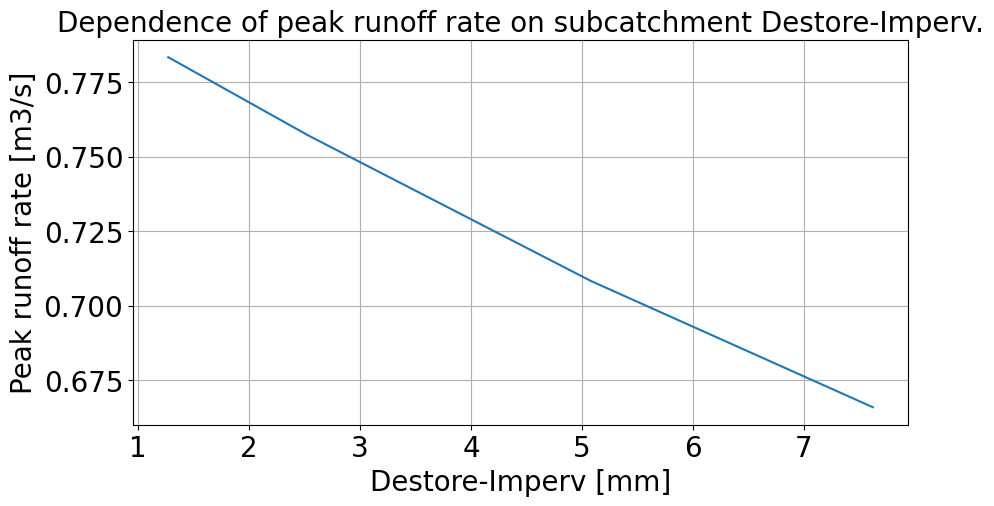

In [56]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_s_imperv['Destore-Imperv'], df_s_imperv['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment Destore-Imperv.')
plt.xlabel('Destore-Imperv [mm]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment Destore-Imperv

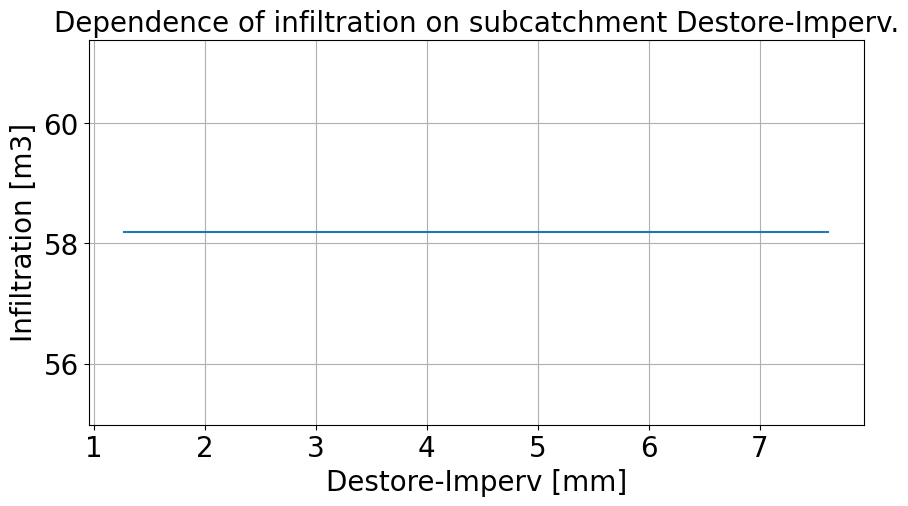

In [57]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_s_imperv['Destore-Imperv'], df_s_imperv['infiltration'])
plt.title('Dependence of infiltration on subcatchment Destore-Imperv.')
plt.xlabel('Destore-Imperv [mm]')
plt.ylabel('Infiltration [m3]')
plt.grid(True)
plt.show()

# Simulate Destore-Perv (Depth of depression storage on Previous area [mm])

## Description
Source: ASCE,(1992), Design & Construction of Urban Stormwater Management Systems, New York, NY.

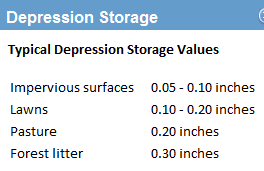



## Prepare method for simulation

In [58]:
def simulate_s_prev(subcatchment_id=None, file_path='example_copy.inp'):
    typical_values = np.sort([0.05, 0.1, 0.2, 0.3])
    typical_values = [val * 25.4 for val in typical_values]
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    model = swmmio.Model(file_path)
    for n in typical_values:
        subareas = model.inp.subareas
        subareas.loc["S1", "S-Perv"] = n
        model.inp.subareas = subareas
        replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)

        with Simulation(model.inp.path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            for _ in sim: pass
            catchment_stats = catchment.statistics
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
    df = pd.DataFrame(data=catchment_data)
    df["Destore-Perv"] = typical_values
    return df

## Get Destore-Imperv data

In [59]:
df_s_perv = simulate_s_prev("S1")

In [60]:
df_s_perv.shape
df_s_perv.head()

,runoff,peak_runoff_rate,infiltration,evaporation,Destore-Perv
0,8291.455217,0.670377,25.359427,0.0,1.27
1,8280.429072,0.669422,36.385436,0.0,2.54
2,8258.625190,0.665897,58.184783,0.0,5.08
3,8237.125354,0.657471,78.412875,0.0,7.62


## Subcatchments data output

In [61]:
# Correlation runoff vs. percent_impervious
df_cor = pd.DataFrame()
df_cor = df_cor.assign(runoff=df_s_perv['runoff'])
df_cor = df_cor.assign(Destore_Perv=df_s_perv['Destore-Perv'])
# df_cor.head()
correlation, p_value = spearmanr(df_cor['runoff'], df_cor['Destore_Perv'])
print(f"Spearman Correlation: {correlation}, P-value: {p_value}")

Spearman Correlation: -1.0, P-value: 0.0


### Dependence of runoff on subcatchment Destore-Imperv.


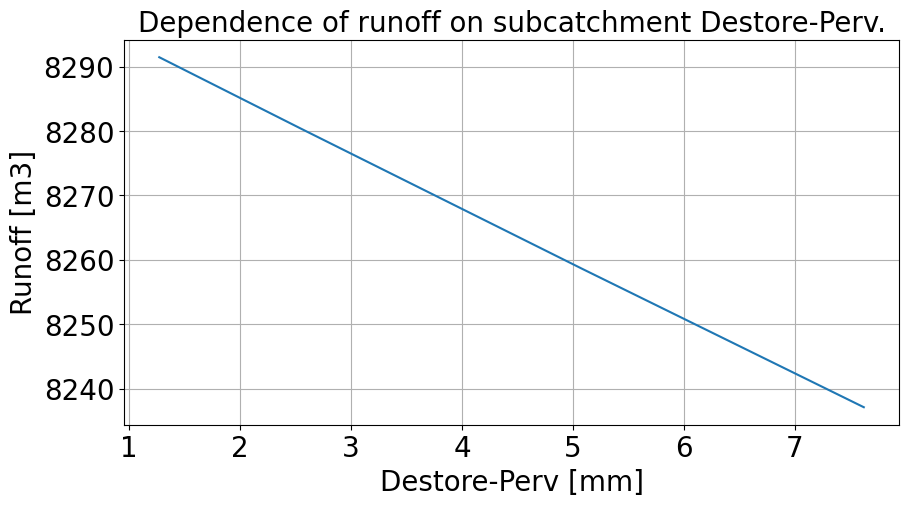

In [62]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_s_perv['Destore-Perv'], df_s_perv['runoff'])
plt.title('Dependence of runoff on subcatchment Destore-Perv.')
plt.xlabel('Destore-Perv [mm]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment Destore-Perv.

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_s_perv['Destore-Perv'], df_s_perv['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment Destore-Perv.')
plt.xlabel('Destore-Perv [mm]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment Destore-Perv

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_s_perv['Destore-Perv'], df_s_perv['infiltration'])
plt.title('Dependence of infiltration on subcatchment Destore-Perv.')
plt.xlabel('Destore-Perv [mm]')
plt.ylabel('Infiltration [m3]')
plt.grid(True)
plt.show()

# Simulate area feature

## Prepare method for simulation

In [ ]:
def simulate_catchments_area(subcatchment_id=None, conduit_id=None, min=1, max=100, step=1, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    area = []
    counter = min
    while counter < max:
        with Simulation(file_path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            conduit = Links(sim)[conduit_id]
            catchment.area = counter
            for _ in sim:
                pass
            catchment_stats = catchment.statistics
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
            area.append(counter)
        counter += step
    catchment_data["area"] = area
    return pd.DataFrame(data=catchment_data)

## Get area data

In [ ]:
df_area = simulate_catchments_area("S1", "C3")

In [ ]:
df_area.head()

## Subcatchments data output

### Dependence of runoff on subcatchment area.

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_area['area'], df_area['runoff'])
plt.title('Dependence of runoff on subcatchment area / odpływ całkowity w funkcji powierzchni terenu.')
plt.xlabel('Area [ha]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment area.

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_area['area'], df_area['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment area / szczytowe tempo odpływu w funkcji powierzchni terenu.')
plt.xlabel('Area [ha]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment area.

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_area['area'], df_area['infiltration'])
plt.title('Dependence of infiltration on subcatchment area')
plt.xlabel('Area [ha]')
plt.ylabel('Infiltration [m3]')
plt.grid(True)
plt.show()

# Simulate width feature

## Prepare method for simulation

In [63]:
def simulate_catchments_width(subcatchment_id=None, conduit_id=None, min=1, max=1000, step=1, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    width = []
    counter = min
    while counter < max:
        with Simulation(file_path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            conduit = Links(sim)[conduit_id]
            catchment.width = counter
            for _ in sim:
                pass
            catchment_stats = catchment.statistics
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
            width.append(counter)
        counter += step
    catchment_data["width"] = width
    return pd.DataFrame(data=catchment_data)

## Get area data

In [64]:
df_width = simulate_catchments_width("S1", "C3")

In [65]:
df_width.head()

,runoff,peak_runoff_rate,infiltration,evaporation,width
0,13.742986,0.000406,87.884480,0.0,1
1,27.425632,0.000811,87.778629,0.0,2
2,41.050684,0.001216,87.676390,0.0,3
3,54.620588,0.001621,87.577539,0.0,4
4,68.137537,0.002026,87.481873,0.0,5


## Subcatchments data output

In [69]:
# Correlation runoff vs. percent_impervious
df_cor = pd.DataFrame()
df_cor = df_cor.assign(runoff=df_width['runoff'])
df_cor = df_cor.assign(width=df_width['width'])
df_cor.head()
correlation, p_value = spearmanr(df_cor['runoff'], df_cor['width'])
print(f"Spearman Correlation: {correlation}, P-value: {p_value}")

Spearman Correlation: 1.0, P-value: 0.0


### Dependence of runoff on subcatchment area.

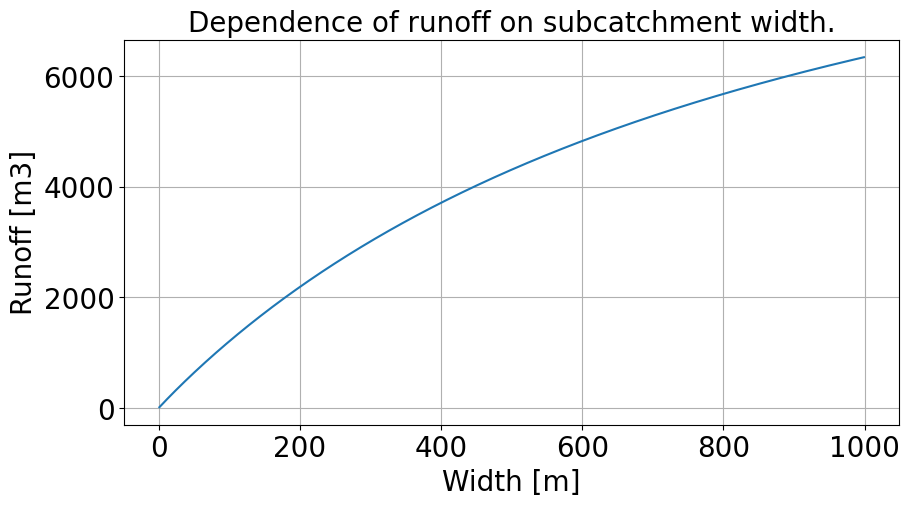

In [67]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_width['width'], df_width['runoff'])
plt.title('Dependence of runoff on subcatchment width.')
plt.xlabel('Width [m]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment area.

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_width['width'], df_width['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment width / szczytowe tempo odpływu w funkcji szerokości ścieżki.')
plt.xlabel('Width [m]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment area.

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_width['width'], df_width['infiltration'])
plt.title('Dependence of infiltration on subcatchment width.')
plt.xlabel('width [m]')
plt.ylabel('Infiltration [m3]')
plt.grid(True)
plt.show()

# Simulate Zero-Imperv (Percent of imprevious area with no depression storage [%])

## Prepare method for simulation

In [70]:
def simulate_zero_imperv(subcatchment_id=None, step=1, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    model = swmmio.Model(file_path)
    zero_imperv = []
    for p in range(0, 101, step):
        zero_imperv.append(p)
        subareas = model.inp.subareas
        subareas.loc["S1", "PctZero"] = p
        model.inp.subareas = subareas
        replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)

        with Simulation(model.inp.path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            for _ in sim: pass
            catchment_stats = catchment.statistics
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
    catchment_data["Zero-Imperv"] = zero_imperv
    return pd.DataFrame(data=catchment_data)

## Get Destore-Imperv data

In [71]:
df_zero_imperv = simulate_zero_imperv("S1")

In [72]:
df_zero_imperv.shape
df_zero_imperv

,runoff,peak_runoff_rate,infiltration,evaporation,Zero-Imperv
0,4386.249428,0.319051,78.412875,0.0,0
1,4441.261941,0.323886,78.412875,0.0,1
2,4496.274454,0.328720,78.412875,0.0,2
3,4551.286968,0.333555,78.412875,0.0,3
4,4606.299481,0.338390,78.412875,0.0,4
...,...,...,...,...,...
96,9667.450698,0.783170,78.412875,0.0,96
97,9722.463211,0.788005,78.412875,0.0,97
98,9777.475724,0.792839,78.412875,0.0,98
99,9832.488238,0.797674,78.412875,0.0,99


## Subcatchments data output

In [73]:
# Correlation runoff vs. percent_impervious
df_cor = pd.DataFrame()
df_cor = df_cor.assign(runoff=df_zero_imperv['runoff'])
df_cor = df_cor.assign(Zero_Imperv=df_zero_imperv['Zero-Imperv'])
df_cor.head()
correlation, p_value = spearmanr(df_cor['runoff'], df_cor['Zero_Imperv'])
print(f"Spearman Correlation: {correlation}, P-value: {p_value}")

Spearman Correlation: 0.9999999999999999, P-value: 0.0


### Dependence of runoff on subcatchment Destore-Imperv.


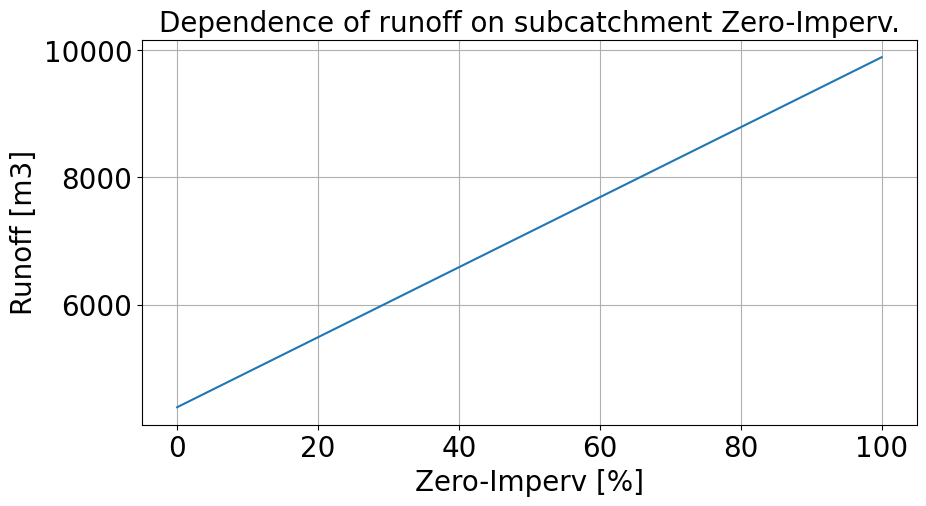

In [74]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_zero_imperv['Zero-Imperv'], df_zero_imperv['runoff'])
plt.title('Dependence of runoff on subcatchment Zero-Imperv.')
plt.xlabel('Zero-Imperv [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment Zero-Imperv.

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_zero_imperv['Zero-Imperv'], df_zero_imperv['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment Zero-Imperv.')
plt.xlabel('Zero-Imperv [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment Zero-Imperv

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_zero_imperv['Zero-Imperv'], df_zero_imperv['infiltration'])
plt.title('Dependence of infiltration on subcatchment Zero-Imperv.')
plt.xlabel('Zero-Imperv [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

# Simulate all feature

## Prepare method for simulation

In [ ]:
def simulate_all_features(subcatchment_id=None, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    model = swmmio.Model(file_path)
    subcatchments = model.inp.subcatchments
    subareas = model.inp.subareas
    # manning_n = np.sort([0.011, 0.012, 0.013, 0.014, 0.015, 0.024, 0.05, 0.06, 0.17, 0.13, 0.15, 0.24, 0.41, 0.4, 0.8])
    manning_n = np.sort([0.015, 0.05, 0.15, 0.24, 0.4, 0.8])
    # manning_n = np.sort([0.011, 0.012])
    # destore = np.array([0.05, 0.1, 0.2, 0.3])
    destore = np.array([0.1, 0.3])

    width = []
    slope = []
    curb_length = []
    n_imperv = []
    n_perv = []
    destore_iperv = []
    destore_perv = []
    zero_imperv = []
    for w in np.arange(100, 1000, 500):
        for s in np.arange(1, 100, 50):
            for cl in np.arange(100, 1000, 500):
                for n_i in manning_n:
                    for n_p in manning_n:
                        for di in destore:
                            for dp in destore:
                                for zi in np.arange(0, 100, 50):
                                    width.append(w)
                                    slope.append(s)
                                    curb_length.append(cl)
                                    n_imperv.append(n_i)
                                    n_perv.append(n_p)
                                    destore_iperv.append(di)
                                    destore_perv.append(dp)
                                    zero_imperv.append(zi)
                                    subcatchments = dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')
                                    subcatchments.loc[subcatchment_id, ["Width", "PercSlope", "CurbLength"]] = [w, s, cl]
                                    subareas.loc[subcatchment_id, ["N-Imperv", "N-Perv", "S-Imperv", "S-Perv", "PctZero"]] = [n_i, n_p, di, dp, zi]
                                    replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)
                                    replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)

                                    with Simulation(model.inp.path) as sim:
                                        catchment = Subcatchments(sim)[subcatchment_id]
                                        for _ in sim: pass
                                        catchment_stats = catchment.statistics
                                        for key in catchment_data:
                                            catchment_data[key].append(catchment_stats[key])
                                print(f"dp: {dp}")
                    print(f"n_i: {n_i}")
                print(f"cl: {cl}")
            print(f"slope: {s}")
        print(f"Loop: {w}")
    df = pd.DataFrame(data=catchment_data)
    df["width"] = width
    df["percent_slope"] = slope
    df["percent_slope"] = slope
    df["curb_length"] = curb_length
    df["n_imperv"] = n_imperv
    df["n_perv"] = n_perv
    df["destore_iperv"] = destore_iperv
    df["destore_perv"] = destore_perv
    df["zero_imperv"] = zero_imperv
    return df

## Get features data

In [ ]:
w100 = pd.read_excel("w0.xlsx")
w250 = pd.read_excel("w250 (1).xlsx")
# w500 = pd.read_excel("w500.xlsx")
w750 = pd.read_excel("w750 (1).xlsx")
# w1000 = pd.read_excel("w1000.xlsx")

In [ ]:
w500 = pd.read_excel("w500.xlsx")


In [ ]:
# frames = [w100, w250, w500, w750, w1000]
frames = [w100, w250, w500, w750]

analyse = pd.concat(frames)

In [ ]:
# analyse = simulate_all_features("S1")
analyse.shape

In [ ]:
analyse[:10]

In [ ]:
analyse.shape

In [ ]:
analyse.to_excel('all_data.xlsx')

## Subcatchments data output

### Show feature correlations

In [ ]:
def simulate_all_features(subcatchment_id=None, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    model = swmmio.Model(file_path)
    subcatchments = model.inp.subcatchments
    subareas = model.inp.subareas
    # manning_n = np.sort([0.011, 0.012, 0.013, 0.014, 0.015, 0.024, 0.05, 0.06, 0.17, 0.13, 0.15, 0.24, 0.41, 0.4, 0.8])
    manning_n = [0.015, 0.05, 0.15, 0.24, 0.4, 0.8]
    # manning_n = np.sort([0.011, 0.012])
    destore = [0.05, 0.1, 0.2, 0.3]
    # destore = np.array([0.1, 0.3])

    width = []
    slope = []
    percent_impervious = []
    n_imperv = []
    n_perv = []
    destore_iperv = []
    destore_perv = []
    zero_imperv = []
    for w in [500]:
        for s in range(0, 101, 10):
            for pi in range(0, 101, 10):
                for n_i in manning_n:
                    for n_p in manning_n:
                        for di in destore:
                            for dp in destore:
                                for zi in np.arange(0, 100, 20):
                                    width.append(w)
                                    slope.append(s)
                                    percent_impervious.append(pi)
                                    n_imperv.append(n_i)
                                    n_perv.append(n_p)
                                    destore_iperv.append(di)
                                    destore_perv.append(dp)
                                    zero_imperv.append(zi)
                                    subcatchments = dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')
                                    subcatchments.loc[subcatchment_id, ["Width", "PercSlope", "CurbLength"]] = [w, s, pi]
                                    subareas.loc[subcatchment_id, ["N-Imperv", "N-Perv", "S-Imperv", "S-Perv", "PctZero"]] = [n_i, n_p, di, dp, zi]
                                    replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)
                                    replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)

                                    with Simulation(model.inp.path) as sim:
                                        catchment = Subcatchments(sim)[subcatchment_id]
                                        for _ in sim: pass
                                        catchment_stats = catchment.statistics
                                        for key in catchment_data:
                                            catchment_data[key].append(catchment_stats[key])
                                print(f"dp: {dp}")
                    print(f"n_i: {n_i}")
                    print(f"cl: {pi}")
                    print(f"slope: {s}")
                    print(f"Loop: {w}")
    df = pd.DataFrame(data=catchment_data)
    df["width"] = width
    df["percent_slope"] = slope
    df["percent_impervious"] = percent_impervious
    df["n_imperv"] = n_imperv
    df["n_perv"] = n_perv
    df["destore_iperv"] = destore_iperv
    df["destore_perv"] = destore_perv
    df["zero_imperv"] = zero_imperv
    return df

In [ ]:
analyse = pd.read_excel('data.xlsx')

In [ ]:
analyse.head()

In [ ]:
analyse.columns

In [ ]:
df_corr = analyse.copy()
corr = df_corr.corr()
# fields = ['evaporation', 'peak_runoff_rate']
# drop rows
# corr.drop(fields, inplace=True)
# drop cols
# corr.drop(fields, axis=1, inplace=True)

sns.set(style="ticks")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(24, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt=".3f",
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8})

In [ ]:
# read dataset
df = analyse.copy()
# get correlations
df_corr = df.corr()
# irrelevant fields
# fields = ['evaporation', 'peak_runoff_rate']
# drop rows
# df_corr.drop(fields, inplace=True)
# drop cols
# df_corr.drop(fields, axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(24, 12))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
# cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".1%",
           linewidths=5, cmap=cmap, vmin=-1, vmax=1,
           cbar_kws={"shrink": .6}, square=True, annot_kws={"size": 14})
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]

plt.yticks(plt.yticks()[0], labels=yticks, rotation=45, fontsize=14, va="top")
plt.xticks(plt.xticks()[0], labels=xticks, rotation=45, fontsize=14, ha="right")

cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=14)

# title
title = 'CORRELATION MATRIX OF SWMM CATCHMENT FEATURES'
plt.title(title, loc='center', fontsize=14)
plt.show()

## Linear regression feature importance

In [ ]:
data = pd.read_excel('data.xlsx')

In [ ]:
df = data.copy()

In [ ]:
df.rename(columns={'TotalRunoffMG': 'Total Runoff'}, inplace=True)

In [ ]:
df.drop(['ImpervRunoff', 'PervRunoff', 'TotalInfil'], axis=1, inplace=True)

In [ ]:
df.columns

In [ ]:
df['Total Runoff'].median()

In [ ]:
df['Total Runoff'].describe()

In [ ]:
df=(df-df.min())/(df.max()-df.min())

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


X = df.loc[:, df.columns != 'Total Runoff']
y = df.loc[:, df.columns == 'Total Runoff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

regresor = LinearRegression()
regresor.fit(X_train, y_train)
pred = regresor.predict(X_test)
importance = regresor.coef_[0]

# for i, v in enumerate(importance):
# 	print(f'Feature: {i}, Score: {v:.2f}')
# plot feature importance

plt.bar([x for x in range(len(importance))], importance)
# ticks
# yticks = [i.upper() for i in corr.index]
xticks = [i.lower() for i in X.columns]

# plt.yticks(plt.yticks()[0], labels=yticks, rotation=45, fontsize=14, va="top")
# print(plt.xticks()[0])
title = 'Weights of variables in the Linear Regression.'
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
plt.title(title, loc='center')
plt.xticks(ticks=np.arange(0, 8, 1), labels=xticks, rotation=45, ha="right")
plt.grid(True)
plt.show()

In [ ]:
# read dataset
df = df.copy()
# get correlations
df_corr = df.corr()
# irrelevant fields
# fields = ['evaporation', 'peak_runoff_rate']
# drop rows
# df_corr.drop(fields, inplace=True)
# drop cols
# df_corr.drop(fields, axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(24, 12))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
# cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
           linewidths=5, cmap=cmap, vmin=-1, vmax=1,
           cbar_kws={"shrink": .6}, square=True, annot_kws={"size": 14})
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]

plt.yticks(plt.yticks()[0], labels=yticks, rotation=45, fontsize=14, va="top")
plt.xticks(plt.xticks()[0], labels=xticks, rotation=45, fontsize=14, ha="right")

cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=14)

# title
title = 'CORRELATION MATRIX OF SWMM CATCHMENT FEATURES'
plt.title(title, loc='center', fontsize=14)
plt.show()

In [ ]:
# https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b - link skąd wziąłem

import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

reg = LassoCV()
reg.fit(X, y)
print("Najlepsza alfa przy użyciu wbudowanego LassoCV: %f" % reg.alpha_)
print("Najlepszy wynik przy użyciu wbudowanego LassoCV: %f" %reg.score (X,y))
coef = pd.Series(reg.coef_, index = X.columns)

print("Lasso wybrał " + str(sum(coef != 0)) + " zmienne i wyeliminował pozostałe " + str(sum(coef == 0)) + " zmienne")

imp_coef = coef.sort_values(ascending=False)
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "bar")
xticks = [i.lower() for i in coef.index]
plt.title("Weights of variables in the LassoCV.", fontsize=20)
plt.xticks(plt.xticks()[0], labels=xticks, rotation=50, fontsize=20, ha="right")
plt.yticks(fontsize=20)
plt.grid(True)
plt.show()

In [ ]:
dfi = data.copy()

In [ ]:
dfi.columns

In [ ]:
dfi.drop(['ImpervRunoff', 'PervRunoff', 'TotalRunoffMG'], axis=1, inplace=True)

In [ ]:
dfi=(dfi-dfi.min())/(dfi.max()-dfi.min())

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


X = dfi.loc[:, dfi.columns != 'TotalInfil']
y = dfi.loc[:, dfi.columns == 'TotalInfil']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

regresor = LinearRegression()
regresor.fit(X_train, y_train)
pred = regresor.predict(X_test)
importance = regresor.coef_[0]

# for i, v in enumerate(importance):
# 	print(f'Feature: {i}, Score: {v:.2f}')
# plot feature importance

plt.bar([x for x in range(len(importance))], importance)
# ticks
# yticks = [i.upper() for i in corr.index]
xticks = [i.lower() for i in X.columns]
title = 'Weights of variables in the Linear Regression.'
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
plt.title(title, loc='center')
plt.xticks(ticks=np.arange(0, 8, 1), labels=xticks, rotation=45, ha="right")
plt.grid(True)
plt.show()

In [ ]:
# read dataset
df = dfi.copy()
# get correlations
df_corr = df.corr()
# irrelevant fields
# fields = ['evaporation', 'peak_runoff_rate']
# drop rows
# df_corr.drop(fields, inplace=True)
# drop cols
# df_corr.drop(fields, axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(24, 12))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
# cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
           linewidths=5, cmap=cmap, vmin=-1, vmax=1,
           cbar_kws={"shrink": .6}, square=True, annot_kws={"size": 14})
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]

plt.yticks(plt.yticks()[0], labels=yticks, rotation=45, fontsize=14, va="top")
plt.xticks(plt.xticks()[0], labels=xticks, rotation=45, fontsize=14, ha="right")

cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=14)

# title
title = 'CORRELATION MATRIX OF SWMM CATCHMENT FEATURES'
plt.title(title, loc='center', fontsize=14)
plt.show()

In [ ]:
# https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b - link skąd wziąłem

import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

reg = LassoCV()
reg.fit(X, y)
# print("Najlepsza alfa przy użyciu wbudowanego LassoCV: %f" % reg.alpha_)
# print("Najlepszy wynik przy użyciu wbudowanego LassoCV: %f" %reg.score (X,y))
coef = pd.Series(reg.coef_, index = X.columns)

# print("Lasso wybrał " + str(sum(coef != 0)) + " zmienne i wyeliminował pozostałe " + str(sum(coef == 0)) + " zmienne")

imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
xticks = [i.lower() for i in coef.index]
imp_coef.plot(kind="bar")
plt.title("Weights of variables in the LassoCV.")
plt.xticks(plt.xticks()[0], labels=xticks, rotation=45, fontsize=20, ha="right")
plt.grid(True)
plt.show()